### Further Reducing Function

In [7]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import scipy

from scipy.signal import sawtooth, square, savgol_filter
import pandas as pd
import glob as gl
import os
import cmath

from scipy.signal import sawtooth, square,find_peaks
from scipy import spatial
# import lambdafit as lf
from scipy.interpolate import CubicSpline,interp1d
import h5py

from tqdm import tqdm as tqdm_terminal
from tqdm.notebook import trange, tqdm_notebook
from scipy.signal.windows import hann

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit

In [8]:
testfile = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/ts_toneinit_fcenter_4250.0_20240216162215_t_20240216163432.hd5'
#testfile = "/Users/leayamashiro/AliCPT/alicpt_data/data_files/ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5"

# Best Working Function as of 1/29
(To include easier parameter option for just single channel)

In [3]:
def read_hdf5_chunk_channels(filename, chunk='all', chunk_start=None, chunk_stop=None, single_channel=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # pre-setting range for the for-loop iterating to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    # iterate depending on chunk argument 
    if chunk == 'all':
        ch = np.array([channel - 22 for channel in buffer_range_fixed])
        t = np.array(file['time_ordered_data']['timestamp'])
        i = np.array([file['time_ordered_data']['adc_i'][channel] for channel in buffer_range_fixed])
        q = np.array([file['time_ordered_data']['adc_q'][channel] for channel in buffer_range_fixed])
        
    elif chunk == 'some': 
        ch = np.array([channel - 22 for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        t = np.array(file['time_ordered_data']['timestamp'])
        i = np.array([file['time_ordered_data']['adc_i'][channel] for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        q = np.array([file['time_ordered_data']['adc_q'][channel] for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        
    elif chunk == 'single':
        ch = np.array(buffer_range_fixed[single_channel] - 22)
        t = np.array(file['time_ordered_data']['timestamp'])
        i = np.array(file['time_ordered_data']['adc_i'][buffer_range_fixed[single_channel]])
        q = np.array(file['time_ordered_data']['adc_q'][buffer_range_fixed[single_channel]])
        
        
    result = {'channel': ch, 't': t, 'i': i, 'q': q}
                      
    return result

In [4]:
test2 = read_hdf5_chunk_channels(testfile, chunk='all')
test2

{'channel': array([   0,    1,    2, ...,  999, 1000, 1001]),
 't': array([1.70813007e+09, 1.70813007e+09, 1.70813007e+09, ...,
        1.70813008e+09, 1.70813008e+09, 1.70813008e+09]),
 'i': array([[ -908,  -905,  -883, ...,  -906,  -916,  -922],
        [-2907, -1877,  -648, ...,  -142,  -215,  -653],
        [-2453, -2449, -2388, ..., -1118,  -619,  -612],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]], dtype=int32),
 'q': array([[ 307,  341,  331, ...,  398,  401,  375],
        [1992,  966, 1136, ..., 1615, 1629, 1297],
        [2983, 3020, 2199, ..., 1279, 1342, 1376],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)}

In [5]:
len(test2['i'])

1002

In [6]:
%matplotlib qt

print(test2['i'][0])

for i in range(len(test2['i'])):
    plt.plot(test2['t'],np.abs(test2['i'][i]+1j*test2['q'][i]) - np.average(np.abs(test2['i'][i]+1j*test2['q'][i])) + i*10000)

[-908 -905 -883 ... -906 -916 -922]


In [1]:
%matplotlib widget

def graph_all(data_list):
    for i in range(len(data_list['i'])):
        t = data_list['t']
        P_ij = np.abs(data_list['i'][i] + 1j*data_list['q'][i]) - np.average(np.abs(data_list['i'][i] + 1j*data_list['q'][i]))
        plt.figure()
        plt.plot(t, P_ij)
        plt.title(f'Channel {i}'.format(str))
    return 

graph_all(test2)


NameError: name 'test2' is not defined

In [15]:
%matplotlib widget

def graph_all(data_list):
    fig, ax = plt.subplots(nrows=len(data_list['i']), ncols=1, figsize=(8, 100))
    for i in range(len(data_list['i'])):
        t = data_list['t']
        P_ij = np.abs(data_list['i'][i] + 1j*data_list['q'][i]) - np.average(np.abs(data_list['i'][i] + 1j*data_list['q'][i]))
        ax[i].plot(t, P_ij + i*3000)
        ax[i].set_title(f'Channel {i}'.format(str))
    return 

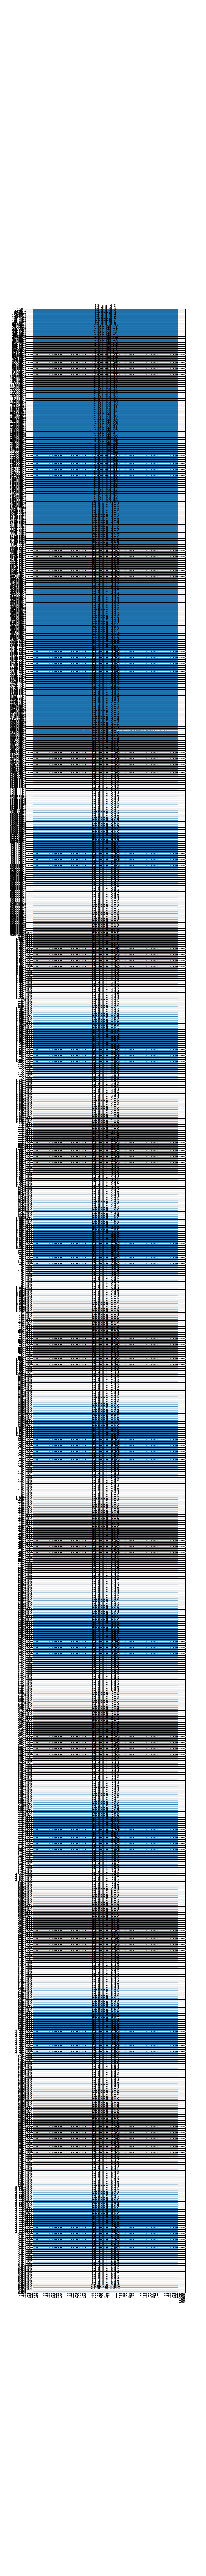

In [16]:
graph_all(test2)

In [14]:
2**16

65536

In [6]:
%matplotlib inline

graph_all: 
for i in range(len(test2['i'])):
    t = test2['t']
    P_ij = np.abs(test2['i'][i] + 1j*test2['q'][i]) - np.average(np.abs(test2['i'][i] + 1j*test2['q'][i]))
    plt.plot(t, P_ij + i*3000)

In [3]:
# function works based on main parameter: 'chunk'
# if chunk = 'all', only first two arguments required, and it will return a list of [t, i, q] dataframes with channel number as a column
# if chunk = 'some', chunk_start and chunk_stop arguments required too, will return same-structured dataframe list as with 'all' 
# if chunk = 'single', single_channel argument required, returns the single channel's dataframe 
# note: including channel number as a column to make slicing easier (rather than having list of 2D elements, i.e. [channel, dataframe])


def read_hdf5_chunk_channels(filename, chunk='all', chunk_start=None, chunk_stop=None, single_channel=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # pre-setting range for the for-loop iterating to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    # iterate depending on chunk argument 
    chunk_list = []
        
    if chunk == 'all': # for all channels
        for channel in buffer_range_fixed: 
            chunk_list.append(pd.DataFrame({'channel': channel - 22,
                                        't': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #'))
    elif chunk == 'some': # for range of channels
        for channel in buffer_range_fixed[chunk_start:chunk_stop]:
            chunk_list.append(pd.DataFrame({'channel': channel - 22,
                                        't': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #'))
    elif chunk == 'single': # for single channel
        channel = buffer_range_fixed[single_channel]
        chunk_list = pd.DataFrame({'channel': channel - 22,
                                    't': np.array(file['time_ordered_data']['timestamp']), 
                                    'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                    'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #')
    # return as list of dataframes of each channel
    return chunk_list

In [29]:
def read_hdf5_chunk_listcomp(filename, chunk='all', chunk_start=None, chunk_stop=None, single_channel=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # pre-setting range for the for-loop iterating to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    
    if chunk == 'all': 
        indexer = buffer_range_fixed[channel]
    elif chunk == 'some':
        some = np.linspace(buffer_range_fixed[chunk_start], buffer_range_fixed[chunk_stop], 1)
        indexer = buffer_range_fixed[some][channel]
    elif chunk == 'single': 
        indexer = single_channel
        
    chunk_list = np.array([pd.DataFrame({'channel': channel-22, 't': np.array(file['time_ordered_data']['timestamp']), 'i':np.array(file['time_ordered_data']['adc_i'][indexer]), 'q': np.array(file['time_ordered_data']['adc_q'][indexer])}).rename_axis('Event #') for channel in buffer_range_fixed])

    return chunk_list

In [ ]:
test_1 = read_hdf5_chunk_listcomp(testfile, chunk='single', single_channel=1)
test_1

In [1]:
# with list comp


def read_hdf5_chunk_(filename, chunk='all', chunk_start=None, chunk_stop=None, single_channel=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # pre-setting range for the for-loop iterating to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    
    chunk_list = [pd.DataFrame({'channel': channel - 22,'t': np.array(file['time_ordered_data']['timestamp']), 'i': np.array(file['time_ordered_data']['adc_i'][channel]), 'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #') if chunk == 'all' else pd.DataFrame({ 'channel': channel - 22, 't': np.array(file['time_ordered_data']['timestamp']),'i': np.array(file['time_ordered_data']['adc_i'][buffer_range_fixed[chunk_start][channel]:buffer_range_fixed[chunk_stop][channel]]), 'q': np.array(file['time_ordered_data']['adc_q'][buffer_range_fixed[chunk_start][channel]:buffer_range_fixed[chunk_stop][channel]])} if chunk == 'some' else pd.DataFrame({ 'channel': channel - 22,'t': np.array(file['time_ordered_data']['timestamp']), 'i': np.array(file['time_ordered_data']['adc_i'][buffer_range_fixed[single_channel]]), 'q': np.array(file['time_ordered_data']['adc_q'][buffer_range_fixed[single_channel]])}).rename_axis('Event #') if chunk == 'single' for channel in buffer_range_fixed]

SyntaxError: '[' was never closed (3290321580.py, line 10)

In [ ]:


a = np.linspace(0,100,100000)


b = np.array([i**2 if i%5 else i**3 for i in a ])

#### Testing with 'some' parameter

In [6]:
test_range = read_hdf5_chunk_channels(testfile, chunk='single', single_channel = 1)#chunk_start=100, chunk_stop=110)
test_range


channel             t     i     q
Event #                                    
0               1  1.709850e+09 -1366  1299
1               1  1.709850e+09  -341  1312
2               1  1.709850e+09    50  1454
3               1  1.709850e+09    85  1549
4               1  1.709850e+09  -147  1459
...           ...           ...   ...   ...
15575003        1  1.709882e+09 -2043  1936
15575004        1  1.709882e+09 -2303  2521
15575005        1  1.709882e+09 -2170  3246
15575006        1  1.709882e+09 -1974  3566
15575007        1  1.709882e+09 -2136  3167

[15575008 rows x 4 columns]

In [10]:
print((test_range['t'].to_numpy(float)[-1] - test_range['t'].to_numpy(float)[0]) / 3600)

8.860580973095365


#### Testing with 'single' parameter

In [59]:
test_single = read_hdf5_chunk_channels(testfile, chunk='single', single_channel=222)
test_single

channel             t    i     q
Event #                                  
0            222  1.715048e+09  563  1012
1            222  1.715048e+09  223   514
2            222  1.715048e+09 -617   286
3            222  1.715048e+09 -194   335
4            222  1.715048e+09  416   823
...          ...           ...  ...   ...
293283       222  1.715048e+09  572  1311
293284       222  1.715048e+09  606  1250
293285       222  1.715048e+09  573  1135
293286       222  1.715048e+09  485   820
293287       222  1.715048e+09 -229   278

[293288 rows x 4 columns]

In [68]:
test_all = read_hdf5_chunk_channels(testfile, chunk='all')

In [70]:
len(test_all)

1002

#### There could also be an advantage to storing these Dataframes in lists with 2D elements containing [channel #, Dataframe], even though slicing by channel should work well enough with the function above. But here's a version with that configuration: 

In [66]:
# function takes arguments based on main parameter: chunk
# if chunk = 'all', only first two arguments required, and it will return a list 2D arrays containing each channel number and its [t, i, q] dataframe
# if chunk = 'some', chunk_start and chunk_stop arguments required too, will return same-structured dataframe list as with 'all' 
# if chunk = 'single', single_channel argument required, returns the single channel's number and dataframe

def read_hdf5_chunk(filename, chunk='all', chunk_start=None, chunk_stop=None, single_channel=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # pre-setting range for the for-loop iterating to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    # create empty list
    chunk_list = []
    # iterate depending on chunk argument 
    if chunk == 'all': # for all channels
        for channel in buffer_range_fixed: 
            chunk_list.append([channel - 22, pd.DataFrame({'t': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #')])
    elif chunk == 'some': # for range of channels
        for channel in buffer_range_fixed[chunk_start:chunk_stop]:
            chunk_list.append([channel - 22, pd.DataFrame({'t': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #')])
    elif chunk == 'single': # for single channel
        channel = buffer_range_fixed[single_channel]
        chunk_list = [channel - 22, pd.DataFrame({'t': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #')]
    # return as list of dataframes of each channel
    return chunk_list

In [67]:
test_2D_chunk_list = read_hdf5_chunk(testfile, chunk='some', chunk_start=130, chunk_stop=137)
test_2D_chunk_list

[[130,
                      t     i     q
  Event #                          
  0        1.715048e+09   755 -1387
  1        1.715048e+09  1393 -1123
  2        1.715048e+09  2207 -1257
  3        1.715048e+09  2895 -1683
  4        1.715048e+09  2819 -1575
  ...               ...   ...   ...
  293283   1.715048e+09   719 -1445
  293284   1.715048e+09   521 -1626
  293285   1.715048e+09   558 -1532
  293286   1.715048e+09   957 -1233
  293287   1.715048e+09  1764 -1170
  
  [293288 rows x 3 columns]],
 [131,
                      t     i     q
  Event #                          
  0        1.715048e+09  2015 -1866
  1        1.715048e+09  3050 -1942
  2        1.715048e+09  3595 -1700
  3        1.715048e+09  3708 -1530
  4        1.715048e+09  3725 -1512
  ...               ...   ...   ...
  293283   1.715048e+09  2329 -1962
  293284   1.715048e+09   925  -561
  293285   1.715048e+09  1071  -948
  293286   1.715048e+09  2600 -1982
  293287   1.715048e+09  3394 -1856
  
  [293288 rows

## Best Working Function as of 12/20

#### Long Version (objects defined before compilation)

In [3]:
# now going on to include chunking as parameter
# NOTE: chunk start and chunk stop has to be entered as a channel of 0 - 1002, taking into account the buffers.
# *conceptually*, the buffer is sliced before any file-reading happens (buffer_range_fixed)
# not as elegant as direct array-slicing, but it allows for function to skip the buffer for indexing all and chunked channels

def read_chunk_range(filename, chunk='all', chunk_start=None, chunk_stop=None):
    
    # read in file
    file = h5py.File(filename, 'r') 
    # setting for-loop iterating range to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    
    # create empty list
    chunk_list = []

    if chunk == 'all': #same operation as "read_data_chunk_faster_pd" function
        for channel in buffer_range_fixed:
            # grab channel info directly from .hd5 file
            i = np.array(file['time_ordered_data']['adc_i'][channel])
            q = np.array(file['time_ordered_data']['adc_q'][channel])
            t = np.array(file['time_ordered_data']['timestamp'])
            # create dataframe object
            channel_df = pd.DataFrame({'t': t, 'i': i, 'q': q})
            channel_df = channel_df.rename_axis('Event #')
            # append each channel's and its dataframe into list (correcting channel # for buffer)
            chunk_list.append([channel - 22, channel_df]) 

    elif chunk == 'some': # same operation, just chunks smaller range
        for channel in buffer_range_fixed[chunk_start:chunk_stop]:
            # grab channel info directly from .hd5 file
            i = np.array(file['time_ordered_data']['adc_i'][channel])
            q = np.array(file['time_ordered_data']['adc_q'][channel])
            t = np.array(file['time_ordered_data']['timestamp'])
            
            # create dataframe object
            channel_df = pd.DataFrame({'t': t, 'i': i, 'q': q})
            channel_df = channel_df.rename_axis('Event #')
            # append each channel's and its dataframe into list (correcting channel # for buffer)
            chunk_list.append([channel - 22, channel_df])

    return chunk_list


In [4]:
# testing new chunking version: 

chunk_range_test = read_chunk_range(testfile, chunk='some', chunk_start=100, chunk_stop=110)
chunk_range_test # prove that it chunked right number of 

[[100,
                      t     i     q
  Event #                          
  0        1.715048e+09 -1487 -1773
  1        1.715048e+09  -927 -2540
  2        1.715048e+09 -1191 -3800
  3        1.715048e+09 -1505 -4143
  4        1.715048e+09  -930 -3293
  ...               ...   ...   ...
  293283   1.715048e+09 -2058 -1417
  293284   1.715048e+09 -2077 -1404
  293285   1.715048e+09 -1818 -1556
  293286   1.715048e+09 -1233 -2024
  293287   1.715048e+09  -908 -3123
  
  [293288 rows x 3 columns]],
 [101,
                      t    i     q
  Event #                         
  0        1.715048e+09 -293 -3293
  1        1.715048e+09   72 -3965
  2        1.715048e+09  312 -4119
  3        1.715048e+09  391 -4172
  4        1.715048e+09  381 -4136
  ...               ...  ...   ...
  293283   1.715048e+09  -95 -2310
  293284   1.715048e+09  763 -1225
  293285   1.715048e+09 -177 -2377
  293286   1.715048e+09 -117 -3690
  293287   1.715048e+09  182 -4037
  
  [293288 rows x 3 columns]

#### Shortened Version (all objects are pulled out of the .hd5 file and manipulated within the "append" operation)

In [5]:
# trying to shorten

def read_chunk_range_short(filename, chunk='all', chunk_start=None, chunk_stop=None):
    
    # read in file
    file = h5py.File(filename, 'r') 
    # setting for-loop iterating range to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    
    # create empty list
    chunk_list = []

    if chunk == 'all': #same operation as "read_data_chunk_faster_pd" function
        for channel in buffer_range_fixed: 
            chunk_list.append([channel - 22, pd.DataFrame({'t': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #')])

    elif chunk == 'some': # same operation, just chunks smaller range
        for channel in buffer_range_fixed[chunk_start:chunk_stop]:
            chunk_list.append([channel - 22, pd.DataFrame({'t': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}).rename_axis('Event #')])
    
    return chunk_list


#### So, this function takes in the file and chunk parameters, directly pulls information from the file for each given channel index, stores a list with 1002 objects of [channel, dataframe], where the dataframe stores each channel's I and Q values along with the timestamp vector and an event # index. This way, you can index the list to get a single channel. If you use the function to get all 1002 channels, this would require just indexing the list by the 1/1002 channel number. 

#### If the function is used to get a chunked range of channels, this would obviously change the indexing properties, which is why I have it saving the original channel number (safety measure for indexing getting confusing); in this scenario, if one wanted to get a single channel out of the chunk, would need to go one step further to find the channel by doing simple list comprehension and find the desired channel within the chunk. 

Tests of the function below: 

In [6]:
chunk_range_shorter_test = read_chunk_range_short(testfile, chunk='all')
print(chunk_range_shorter_test[100]) # see whole [channel, dataframe] vector
chunk_range_shorter_test[100][1] # see just the dataframe

[100,                     t     i     q
Event #                          
0        1.715048e+09 -1487 -1773
1        1.715048e+09  -927 -2540
2        1.715048e+09 -1191 -3800
3        1.715048e+09 -1505 -4143
4        1.715048e+09  -930 -3293
...               ...   ...   ...
293283   1.715048e+09 -2058 -1417
293284   1.715048e+09 -2077 -1404
293285   1.715048e+09 -1818 -1556
293286   1.715048e+09 -1233 -2024
293287   1.715048e+09  -908 -3123

[293288 rows x 3 columns]]


t     i     q
Event #                          
0        1.715048e+09 -1487 -1773
1        1.715048e+09  -927 -2540
2        1.715048e+09 -1191 -3800
3        1.715048e+09 -1505 -4143
4        1.715048e+09  -930 -3293
...               ...   ...   ...
293283   1.715048e+09 -2058 -1417
293284   1.715048e+09 -2077 -1404
293285   1.715048e+09 -1818 -1556
293286   1.715048e+09 -1233 -2024
293287   1.715048e+09  -908 -3123

[293288 rows x 3 columns]

In [7]:
chunk_range_shorter_test_2 = read_chunk_range_short(testfile, chunk='some', chunk_start=100, chunk_stop=110) # looking at only a chunk
chunk_range_shorter_test_2

[[100,
                      t     i     q
  Event #                          
  0        1.715048e+09 -1487 -1773
  1        1.715048e+09  -927 -2540
  2        1.715048e+09 -1191 -3800
  3        1.715048e+09 -1505 -4143
  4        1.715048e+09  -930 -3293
  ...               ...   ...   ...
  293283   1.715048e+09 -2058 -1417
  293284   1.715048e+09 -2077 -1404
  293285   1.715048e+09 -1818 -1556
  293286   1.715048e+09 -1233 -2024
  293287   1.715048e+09  -908 -3123
  
  [293288 rows x 3 columns]],
 [101,
                      t    i     q
  Event #                         
  0        1.715048e+09 -293 -3293
  1        1.715048e+09   72 -3965
  2        1.715048e+09  312 -4119
  3        1.715048e+09  391 -4172
  4        1.715048e+09  381 -4136
  ...               ...  ...   ...
  293283   1.715048e+09  -95 -2310
  293284   1.715048e+09  763 -1225
  293285   1.715048e+09 -177 -2377
  293286   1.715048e+09 -117 -3690
  293287   1.715048e+09  182 -4037
  
  [293288 rows x 3 columns]

# IGNORE PAST THIS POINT 
#### (It was just previous versions of functions)

In [30]:
# goal is to just have a function that chunks out each channel into individual chunks that can be analyzed separately

def read_chunk_channels(filename):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    #initialize channel data dictionary
    channel_dict = {}

    # create structured array [t, i, q] for each channel
    for channel in range(i.shape[0]):
        # then store each channel as dataframe
        freqs_frame = pd.DataFrame({'t':t, 
                                    'i': i[channel], 
                                    'q': q[channel]
                                    })
        # store channel n in the greater dictionary
        channel_dict[channel] = freqs_frame
    
    return channel_dict

In [39]:
all_channels_chunk_test = read_chunk_channels(testfile)
for i in range(1, 5):
    print(f'Channel {i}:', all_channels_chunk_test[i])

Channel 1:                    t     i     q
0       1.715048e+09  2374 -1274
1       1.715048e+09  3048 -2202
2       1.715048e+09  3034 -2376
3       1.715048e+09  2468 -1470
4       1.715048e+09  1245 -1046
...              ...   ...   ...
293283  1.715048e+09   203 -1725
293284  1.715048e+09   609 -1395
293285  1.715048e+09  1595 -1066
293286  1.715048e+09  2737 -1603
293287  1.715048e+09  3039 -2432

[293288 rows x 3 columns]
Channel 2:                    t     i    q
0       1.715048e+09  1422 -416
1       1.715048e+09  2241  -82
2       1.715048e+09  3184 -324
3       1.715048e+09  3610 -694
4       1.715048e+09  3216 -370
...              ...   ...  ...
293283  1.715048e+09  1088 -829
293284  1.715048e+09  1018 -952
293285  1.715048e+09  1148 -753
293286  1.715048e+09  1677 -223
293287  1.715048e+09  2595  -97

[293288 rows x 3 columns]
Channel 3:                    t     i     q
0       1.715048e+09   631 -1878
1       1.715048e+09  1456 -2634
2       1.715048e+09  1705 -3489
3

In [33]:
len(all_channels_chunk_test)

1002

## LEAVE THIS CELL BELOW

In [60]:
# USING LIST instead of dictionary

# goal is to just have a function that chunks out each channel into individual chunks that can be analyzed separately

def read_chunk_channels_np(filename):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    #initialize channel list
    channel_list = []

    # create structured array [t, i, q] for each channel
    for channel in range(i.shape[0]):
        channel_list.append([{'t': t, 'i': i[channel], 'q': q[channel]}])

    channels_compiled = np.concatenate(channel_list, axis=0)
    
    return channels_compiled


def read_chunk_channels_dfs(filename):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    #initialize channel list
    channel_list = []

    # create structured array [t, i, q] for each channel
    for channel in range(i.shape[0]):
        channel_list.append(pd.DataFrame({'t': t, 
                                          'i': i[channel], 
                                          'q': q[channel]}))

    return channel_list


In [49]:
test0_np = read_chunk_channels_np(testfile)
print(len(test0_np))
print(test0_np.shape)

1002
(1002,)


In [59]:
test0_pd = read_chunk_channels_dfs(testfile)
print(len(test0_pd))
test0_pd[0]

1002


t    i    q
0       1.715048e+09  587 -961
1       1.715048e+09  535 -953
2       1.715048e+09  515 -949
3       1.715048e+09  487 -933
4       1.715048e+09  504 -910
...              ...  ...  ...
293283  1.715048e+09  574 -947
293284  1.715048e+09  582 -963
293285  1.715048e+09  537 -955
293286  1.715048e+09  564 -943
293287  1.715048e+09  534 -911

[293288 rows x 3 columns]

### leave this cell alone

In [102]:
# now faster, try to index with the for-loop without having to make a whole array first

def read_data_chunk_faster_pd(filename): # chunk='all', chunk_start=None, chunk_stop=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # setting for-loop iterating range to fix the 0-22 rows of resonator buffer
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 

    # create empty list
    chunk_list = []

    for channel in buffer_range_fixed:
        # grab channel info directly from .hd5 file
        i = np.array(file['time_ordered_data']['adc_i'][channel])
        q = np.array(file['time_ordered_data']['adc_q'][channel])
        t = np.array(file['time_ordered_data']['timestamp'])
        
        # create dataframe object
        channel_df = pd.DataFrame({'t': t, 'i': i, 'q': q})
        channel_df = channel_df.rename_axis('Event #')

        # append each channel's dataframe into list
        chunk_list.append(channel_df)

    return chunk_list


# further collapsing: 
def read_data_chunk_faster_pd_again(filename): # chunk='all', chunk_start=None, chunk_stop=None):
    # read in file
    file = h5py.File(filename, 'r') 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) # setting iterating range to fix the 0-22 rows of resonator buffer

    # create empty list
    chunk_list = []

    # iterate through all of the 1002 channels, create a dataframe for each individual channel, append it to list
    for channel in buffer_range_fixed: 
        chunk_list.append(pd.DataFrame({'t': np.array(file['time_ordered_data']['timestamp']), 
                                        'i': np.array(file['time_ordered_data']['adc_i'][channel]), 
                                        'q': np.array(file['time_ordered_data']['adc_q'][channel])}))
    return chunk_list
        



In [103]:
pd_faster_test = read_data_chunk_faster_pd(testfile)
pd_faster_test[100:200] # show that a sub-list can be indexed of whole set. 

[                    t     i     q
 Event #                          
 0        1.715048e+09 -1487 -1773
 1        1.715048e+09  -927 -2540
 2        1.715048e+09 -1191 -3800
 3        1.715048e+09 -1505 -4143
 4        1.715048e+09  -930 -3293
 ...               ...   ...   ...
 293283   1.715048e+09 -2058 -1417
 293284   1.715048e+09 -2077 -1404
 293285   1.715048e+09 -1818 -1556
 293286   1.715048e+09 -1233 -2024
 293287   1.715048e+09  -908 -3123
 
 [293288 rows x 3 columns],
                     t    i     q
 Event #                         
 0        1.715048e+09 -293 -3293
 1        1.715048e+09   72 -3965
 2        1.715048e+09  312 -4119
 3        1.715048e+09  391 -4172
 4        1.715048e+09  381 -4136
 ...               ...  ...   ...
 293283   1.715048e+09  -95 -2310
 293284   1.715048e+09  763 -1225
 293285   1.715048e+09 -177 -2377
 293286   1.715048e+09 -117 -3690
 293287   1.715048e+09  182 -4037
 
 [293288 rows x 3 columns],
                     t     i     q
 Event #

In [76]:
pd_faster_test_2 = read_data_chunk_faster_pd_again(testfile)
pd_faster_test_2[100] # show that channel 100 can be indexed directly from object

t     i     q
0       1.715048e+09 -1487 -1773
1       1.715048e+09  -927 -2540
2       1.715048e+09 -1191 -3800
3       1.715048e+09 -1505 -4143
4       1.715048e+09  -930 -3293
...              ...   ...   ...
293283  1.715048e+09 -2058 -1417
293284  1.715048e+09 -2077 -1404
293285  1.715048e+09 -1818 -1556
293286  1.715048e+09 -1233 -2024
293287  1.715048e+09  -908 -3123

[293288 rows x 3 columns]

Note: Those two functions are identical in concept and had equivalent run-times for same cell operation. Difference is that in the first, the array objects are defined before going into the DataFrame, which helps to see. Because they have the same run-time and it helps conceptually to see them, I'm going keep working with the first one. 

In [96]:
file = h5py.File(testfile, 'r') 
file['time_ordered_data']['adc_i'].shape[0]
buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
len(buffer_range_fixed)

1002

In [45]:
test0[3:10]

array([{'t': array([1.71504782e+09, 1.71504782e+09, 1.71504782e+09, ...,
              1.71504842e+09, 1.71504842e+09, 1.71504842e+09]), 'i': array([ 631, 1456, 1705, ...,   17,  977, 1627], dtype=int32), 'q': array([-1878, -2634, -3489, ..., -1824, -2027, -2931], dtype=int32)},
       {'t': array([1.71504782e+09, 1.71504782e+09, 1.71504782e+09, ...,
              1.71504842e+09, 1.71504842e+09, 1.71504842e+09]), 'i': array([-1196,  -278,   387, ..., -1577,  -906,    44], dtype=int32), 'q': array([-1783, -2160, -3214, ..., -1741, -1840, -2438], dtype=int32)},
       {'t': array([1.71504782e+09, 1.71504782e+09, 1.71504782e+09, ...,
              1.71504842e+09, 1.71504842e+09, 1.71504842e+09]), 'i': array([-3490, -3951, -4043, ..., -2638, -3770, -4017], dtype=int32), 'q': array([2486, 2286, 2177, ..., 2297, 2391, 2192], dtype=int32)},
       {'t': array([1.71504782e+09, 1.71504782e+09, 1.71504782e+09, ...,
              1.71504842e+09, 1.71504842e+09, 1.71504842e+09]), 'i': array([-232,

In [10]:
# starting-level reduced function from previous, in that not all channels are compiled into dataframe.
# but the actual reading-in of the file still takes the whole set of arrays for each stream

def read_chunk_isolate_channel_time_reduced_pd(filename, single_channel, time='all', t_index_start=None, t_index_stop=None):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    if single_channel >= i.shape[0]:
        raise ValueError(f"channel {single_channel} not found")
    
    i_data = i[single_channel]
    q_data = q[single_channel]

    selected_channel_frame = pd.DataFrame({'t': t, 
                                           'i': i_data,
                                           'q': q_data
                                           })

    selected_channel_frame = selected_channel_frame.rename_axis('Event')

    # getting desired time chunk range (all or specific)
    if time == 'all':
        chunked_channel_time = selected_channel_frame
    elif time == 'some':
        if t_index_start is None or t_index_stop is None: 
            raise ValueError('provide slice boundaries for time = some')
        chunked_channel_time = selected_channel_frame.iloc[t_index_start:t_index_stop]

    return chunked_channel_time


# testing

testpdred_t_all = read_chunk_isolate_channel_time_reduced_pd(filename = testfile,
                                           single_channel = 100,
                                            time = 'all')
testpdred_t_some = read_chunk_isolate_channel_time_reduced_pd(filename = testfile,
                                           single_channel = 100,
                                            time = 'some', 
                                            t_index_start = 100000, 
                                            t_index_stop = 150000)

print(testpdred_t_all.head(5))
print(testpdred_t_some.head(5))


                  t     i     q
Event                          
0      1.715048e+09 -1487 -1773
1      1.715048e+09  -927 -2540
2      1.715048e+09 -1191 -3800
3      1.715048e+09 -1505 -4143
4      1.715048e+09  -930 -3293
                   t     i     q
Event                           
100000  1.715048e+09 -1674 -1621
100001  1.715048e+09 -1086 -2245
100002  1.715048e+09  -992 -3429
100003  1.715048e+09 -1532 -4132
100004  1.715048e+09 -1098 -3674


So we know it works. But the problem seems to lie in the reading in of the files, which happens in the creation of the arrays(?) And that is probably where we want to be indexing and chunking to begin with. One problem is that there is this issue of (0-22) resonators needing to be sliced off, but not that much of an issue. Can just adjust for that. Now I will start on that journey... 

So: 
1. Define arguments (with 0-22 slice)
2. Load in file
3. make arrays 

In [13]:
file = h5py.File(testfile, 'r')
i = np.array(file['time_ordered_data']['adc_i'][100])

293288

In [26]:
# new function that indexes the channel right away

def read_data_chunk(filename, single_channel, time='all', ind_start=None, ind_stop=None): 
    # the channel we're looking for is out of 1002, not out of 1024
    # so if the input argument is going to be a channel from 1002, then need to adjust input
    selected_channel = single_channel + 22

    # read in file
    file = h5py.File(filename, 'r') 
    
    # make sure channel exists in range
    if selected_channel >= file['time_ordered_data']['adc_i'][selected_channel].shape[0] - 23:
        raise ValueError(f"channel {single_channel} not in range")
    
    # make i, q arrays with channel index, and full normal timestamp array =
    i = np.array(file['time_ordered_data']['adc_i'][selected_channel])
    q = np.array(file['time_ordered_data']['adc_q'][selected_channel])
    t = np.array(file['time_ordered_data']['timestamp'])

    selected_channel_frame = pd.DataFrame({'timestamp': t, 
                                           'I': i,
                                           'Q': q
                                           })
    
    # just renaming index 
    selected_channel_frame = selected_channel_frame.rename_axis('Event #')

    # if getting desired time chunk range (all or specific)
    if time == 'all':
        chunked_channel_time = selected_channel_frame
    elif time == 'some':
        if ind_start is None or ind_stop is None: 
            raise ValueError('provide index slice boundaries for time = some')
        chunked_channel_time = selected_channel_frame.iloc[ind_start:ind_stop]

    return chunked_channel_time

In [29]:
# test function: 

test1 = read_data_chunk(filename = testfile, 
                        single_channel = 100, 
                        time = 'all')

test1

timestamp     I     Q
Event #                          
0        1.715048e+09 -1487 -1773
1        1.715048e+09  -927 -2540
2        1.715048e+09 -1191 -3800
3        1.715048e+09 -1505 -4143
4        1.715048e+09  -930 -3293
...               ...   ...   ...
293283   1.715048e+09 -2058 -1417
293284   1.715048e+09 -2077 -1404
293285   1.715048e+09 -1818 -1556
293286   1.715048e+09 -1233 -2024
293287   1.715048e+09  -908 -3123

[293288 rows x 3 columns]

Okay so that works. Seems to work okay! Now try to do it with channel chunking -- like if we wanted to get object holding the [t, i, q] dataframes of first 200 channels.

In [28]:
# inputs will now include if-contingent arguments for either a single channel or a range of channels
# this will end up with different outputs...
# for plotting it could be more useful to have these as arrays in the chunked

def read_data_chunk(filename, chans = 'single', single_channel,
                    channel_start = None, channel_stop = None,  
                    time='all', ind_start=None, ind_stop=None): 
    # the channel we're looking for is out of 1002, not out of 1024
    # so if the input argument is going to be a channel from 1002, then need to adjust input
    selected_channel = single_channel + 22

    # read in file
    file = h5py.File(filename, 'r') 
    
    # make sure channel exists in range
    if selected_channel >= file['time_ordered_data']['adc_i'][selected_channel].shape[0] - 23:
        raise ValueError(f"channel {single_channel} not in range")
    
    # make i, q arrays with channel index, and full normal timestamp array
    i = np.array(file['time_ordered_data']['adc_i'][selected_channel])
    q = np.array(file['time_ordered_data']['adc_q'][selected_channel])
    t = np.array(file['time_ordered_data']['timestamp'])

    selected_channel_frame = pd.DataFrame({'timestamp': t, 
                                           'I': i,
                                           'Q': q
                                           })
    
    # just renaming index 
    selected_channel_frame = selected_channel_frame.rename_axis('Event #')

    # if getting desired time chunk range (all or specific)
    if time == 'all':
        chunked_channel_time = selected_channel_frame
    elif time == 'some':
        if ind_start is None or ind_stop is None: 
            raise ValueError('provide index slice boundaries for time = some')
        chunked_channel_time = selected_channel_frame.iloc[ind_start:ind_stop]

    return chunked_channel_time

timestamp     I     Q
Event #                          
0        1.715048e+09 -1487 -1773
1        1.715048e+09  -927 -2540
2        1.715048e+09 -1191 -3800
3        1.715048e+09 -1505 -4143
4        1.715048e+09  -930 -3293
...               ...   ...   ...
293283   1.715048e+09 -2058 -1417
293284   1.715048e+09 -2077 -1404
293285   1.715048e+09 -1818 -1556
293286   1.715048e+09 -1233 -2024
293287   1.715048e+09  -908 -3123

[293288 rows x 3 columns]

In [ ]:
def read_chunk_channels(filename):# single_channel, time='all', t_start=0, t_stop=28000):
    file = h5py.File(filename, 'r')
    # make arrays 
    i = np.array(file['time_ordered_data']['adc_i'])
    i = np.delete(i, slice(0,22), 0)
    q = np.array(file['time_ordered_data']['adc_q'])
    q = np.delete(q, slice(0,22), 0)
    t = np.array(file['time_ordered_data']['timestamp'])
    
    #initialize channel data dictionary
    channel_dict = {}

    # create structured array [t, i, q] for each channel
    for channel in range(i.shape[0]):
        # then store each channel as dataframe
        freqs_frame = pd.DataFrame({'t':t, 
                                    'i': i[channel], 
                                    'q': q[channel]
                                    })
        # store channel n in the greater dictionary
        channel_dict[channel] = freqs_frame
    
    return channel_dict

In [19]:
#list comprehension example

a = np.linspace(0,100,100000)


b = np.array([])
for i in a:
    if i%5:
        b = np.append(b,i**2)
    else:
        b = np.append(b,i**3)

In [18]:


a = np.linspace(0,100,100000)


b = np.array([i**2 if i%5 else i**3 for i in a ])

In [16]:
b = a**2

print(b)

[0.00000e+00 1.00002e-06 4.00008e-06 ... 9.99960e+03 9.99980e+03
 1.00000e+04]
